# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация
Дата выдачи: 05.02.2021

Мягкий дедлайн: 01:59MSK 21.02.2021

Жесткий дедлайн: 01:59MSK 24.02.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

*Примечание: в classifier будем сразу подавать линейную модель (для корректной работы должна иметь метод predict_proba или decision_function).*

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import math
import random

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier=LogisticRegression()):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        modified: classifier, linear classification model
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
    
    def decode(self, i):    # for pair generator
        k = math.floor((1+math.sqrt(1+8*i))/2)
        return [k,i-k*(k-1)//2]

    def rand_pairs(self, n, m):    # pair generator
        return np.array([self.decode(i) for i in random.sample(range(n*(n-1)//2),m)])
    
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        if self.use_PCA:
            self.pca_ = PCA(n_components=self.new_dim)
            self.pca_.fit(X)
            X = self.pca_.transform(X)
        
        idx = self.rand_pairs(X.shape[0], 1000000)
        #idx = np.random.choice(range(X.shape[0]),size=(1000000, 2))
        sigma_sq = np.median(((X[idx[:,0]] - X[idx[:,1]]) ** 2).sum(axis=1))
        self.weights_ = np.random.normal(0, 1/np.sqrt(sigma_sq), (self.n_features, X.shape[1]))
        self.intercept_ = np.random.uniform(-np.pi, np.pi, self.n_features)
        X_new = np.cos(X.dot(self.weights_.T) + self.intercept_)

        self.classifier.fit(X_new, y)
        return self
        raise NotImplementedError


    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        if self.use_PCA:
            X = self.pca_.transform(X)

        X_new = np.cos(X.dot(self.weights_.T) + self.intercept_)
        if hasattr(self.classifier, 'predict_proba'):
            return self.classifier.predict_proba(X_new)
        else:
            if hasattr(self.classifier, 'decision_function'):
                return 1 / (1 + np.exp(-self.classifier.decision_function(X_new)))    # sigmoid
        raise NotImplementedError
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        if hasattr(self.classifier, 'classes_'):
            return self.classifier.classes_[np.argmax(self.predict_proba(X), axis=1)]
        return np.argmax(self.predict_proba(X), axis=1)
        raise NotImplementedError

*Logistic regression:*

In [4]:
rff_model = RFFPipeline()
rff_model.fit(x_train, y_train)

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RFFPipeline()

In [5]:
from sklearn.metrics import accuracy_score

preds_train = rff_model.predict(x_train)
train_score = accuracy_score(y_train, preds_train)
preds = rff_model.predict(x_test)
test_score = accuracy_score(y_test, preds)

print('Train accuracy: %.4f' % train_score)
print('Test accuracy: %.4f' % test_score)

Train accuracy: 0.8751
Test accuracy: 0.8580


*Linear SVM:*

In [6]:
rff_model_svm = RFFPipeline(classifier=LinearSVC())
rff_model_svm.fit(x_train, y_train)

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


RFFPipeline(classifier=LinearSVC())

In [7]:
preds_train_svm = rff_model_svm.predict(x_train)
train_score_svm = accuracy_score(y_train, preds_train_svm)
preds_svm = rff_model_svm.predict(x_test)
test_score_svm = accuracy_score(y_test, preds_svm)

print('Train accuracy: %.4f' % train_score_svm)
print('Test accuracy: %.4f' % test_score_svm)

Train accuracy: 0.9093
Test accuracy: 0.8727


__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

*Рассмотрим скорость обучения (на x_train) и применения модели (на x_test) со случайными признаками:*

In [8]:
%%timeit -r 3
rff_model.fit(x_train, y_train)

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

4min 2s ± 34.7 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
%%timeit -r 3
rff_model.predict(x_test)

1.44 s ± 42.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


*Модель обучается примерно за 4 минуты, применяется за 1.44 секунд.*

*Рассмотрим результаты модели SVM (линейную и с гауссовым ядром), скорость их обучения и применения:*

In [10]:
from sklearn.svm import SVC

lin_svc = LinearSVC()
kern_svc = SVC()    # default kernel = 'rbf' - gaussian
subset_idx = random.sample(range(x_train.shape[0]), 20000)    # train on subset for faster learning

In [11]:
import time
start_time = time.time()
lin_svc.fit(x_train, y_train)
print('Linear SVC fitting time: %.4f s' % (time.time() - start_time))

Linear SVC fitting time: 771.9873 s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [12]:
start_time = time.time()
lin_svc_preds = lin_svc.predict(x_test)
print('Linear SVC predicting time: %.4f s' % (time.time() - start_time))

Linear SVC predicting time: 0.2680 s


*Линейный SVM обучается (на всём x_train) примерно за 12 минут, применяется за 0.27 секунд.*

In [13]:
start_time = time.time()
kern_svc.fit(x_train[subset_idx], y_train[subset_idx])
print('Kernel SVC fitting time: %.4f s' % (time.time() - start_time))

Kernel SVC fitting time: 216.8893 s


In [14]:
start_time = time.time()
kern_svc_preds = kern_svc.predict(x_test)
print('Kernel SVC predicting time: %.4f s' % (time.time() - start_time))

Kernel SVC predicting time: 213.7479 s


*Ядровой SVM обучается (на 20к объектах - третья часть x_train) примерно за 3.6 минут, применяется за 3.5 минуты.*

In [15]:
lin_svc_train_preds = lin_svc.predict(x_train)
kern_svc_train_preds = kern_svc.predict(x_train)

In [16]:
lsvc_scores = (accuracy_score(y_train, lin_svc_train_preds), accuracy_score(y_test, lin_svc_preds))
ksvc_scores = (accuracy_score(y_train, kern_svc_train_preds), accuracy_score(y_test, kern_svc_preds))

print('Linear SVC on initial features:')
print('\t Train accuracy: %.4f \t Test accuracy: %.4f' % lsvc_scores)
print('Kernel SVC on initial features:')
print('\t Train accuracy: %.4f \t Test accuracy: %.4f' % ksvc_scores)

Linear SVC on initial features:
	 Train accuracy: 0.7806 	 Test accuracy: 0.7535
Kernel SVC on initial features:
	 Train accuracy: 0.8843 	 Test accuracy: 0.8672


*Как можно заметить, при использовании линейного SVM на исходных признаках точность (0.75) получается на 0.1 ниже результата работы модели со случайными признаками (0.85). При этом линейный SVM долго обучается (10-12 минут), поэтому из всех рассмотренных подходов эта модель является наименее удачной. Ядровой SVM по точности получается примерно таким же, как и модель с RFF (0.86), однако скорость его обучения и применения дольше (уже на трети выборки модель обучается 3.6 минут), более того, модель с RFF с использованием линейного SVM выдаёт более высокую точность (0.9 на обучающей выборке, 0.87 на тестовой, впрочем, скорость обучения значительно становится медленнее относительно модели c RFF с использованием логистической регрессии).*

*Рассмотрим модель XGBoost с понижением размерности с PCA. Предварительно подберём значения числа деревьев и шага обучения:*

In [17]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
n_est_grid = np.arange(6,20,2)
lr_grid = np.linspace(1e-6,1,10)

best_xgb = None
best_xgb_score = 0
for n in n_est_grid:
    for lr in lr_grid:
        xgb = Pipeline([
            ('pca', PCA(n_components=50)),
            ('xgb', XGBClassifier(use_label_encoder=False,n_estimators=n, learning_rate=lr))
        ])
        xgb.fit(x_train, y_train)
        xgb_score = accuracy_score(xgb.predict(x_test), y_test)
        if (xgb_score > best_xgb_score):
            best_xgb_score = xgb_score
            best_xgb = xgb

[03:02:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:03:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:03:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:04:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[03:19:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:20:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:20:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:21:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[03:44:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:45:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:46:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:48:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

In [18]:
start_time = time.time()
best_xgb.fit(x_train, y_train)
print('PCA + XGBoost fitting time: %.4f s' % (time.time() - start_time))

[11:52:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
PCA + XGBoost fitting time: 80.7980 s


In [19]:
%%timeit
best_xgb.predict(x_test)

155 ms ± 2.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


*Время обучения модели PCA + XGBoost: 81 секунд, применения: 155 миллисекунд.*

In [20]:
xgb_train_preds = best_xgb.predict(x_train)
xgb_preds = best_xgb.predict(x_test)

In [21]:
print('PCA + XGBoost:')
print('\t Train accuracy: %.4f \t Test accuracy: %.4f' % 
      (accuracy_score(y_train, xgb_train_preds),accuracy_score(y_test, xgb_preds)))

PCA + XGBoost:
	 Train accuracy: 0.9155 	 Test accuracy: 0.8504


*Как можно заметить, по качеству работы модель с PCA и XGBoost похожа на результат модели с RFF и линейным SVM, однако точность у модели с бустингом на обучающей выборке выше (0.91, у RFF+SVM - 0.9), но на тестовой ниже (0.85, у RFF+SVM - 0.87). С другой стороны, модель с бустингом обучается и применяется в несколько раз быстрее (1.2 минуты и 155 мс, тогда как RFF+Logreg обучается за 4 минуты и применяется за 1 минуту, RFF+SVM обучается ещё медленнее). Поэтому, модель с понижением размерности с помощью PCA и использованием градиентного бустинга, как и модель со случайными признаками можно считать удачными.*

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

1) *Рассмотрим модель без PCA:*

In [22]:
rff_no_pca = RFFPipeline(use_PCA=False)
rff_no_pca.fit(x_train, y_train)

no_pca_train_preds = rff_no_pca.predict(x_train)
no_pca_preds = rff_no_pca.predict(x_test)

print('Train accuracy: %.4f' % accuracy_score(y_train, no_pca_train_preds))
print('Test accuracy: %.4f' % accuracy_score(y_test, no_pca_preds))

Train accuracy: 0.1889
Test accuracy: 0.1098


*Точность на тестовой выборке - 11%, тогда как в первом задании модель с использованием PCA дала результат в несколько раз лучше - 85%. Значит, предварительное понижение размерности с помощью PCA существенно влияет на качество модели.*

*Примечание: на этом моменте у меня умер kernel, поэтому нумерация немного непоследовательная.*

2) *Рассмотрим зависимость качества модели от значения параметра n_features:*

In [5]:
n_ft_grid = np.logspace(1,4,20)    # take int
acc_train = []
acc_test = []

for n in n_ft_grid:
    model = RFFPipeline(n_features = int(n))
    model.fit(x_train, y_train)
    acc_train.append(accuracy_score(y_train, model.predict(x_train)))
    acc_test.append(accuracy_score(y_test, model.predict(x_test)))

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

MemoryError: Unable to allocate 4.47 GiB for an array with shape (60000, 10000) and data type float64

*Примечание: на 10к признаков не хватило памяти (поэтому на графике берётся n_ft_grid[:-1]).*

*Нарисуем график зависимости точности на обучающей и тестовой выборках в зависимости от n_features:*

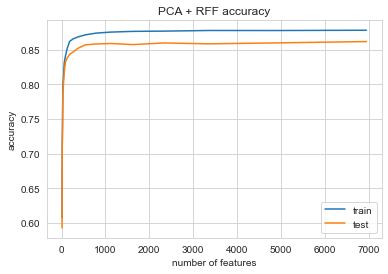

In [18]:
plt.plot([int(n) for n in n_ft_grid][:-1], acc_train, label='train')
plt.plot([int(n) for n in n_ft_grid][:-1], acc_test, label='test')
plt.xlabel('number of features')
plt.ylabel('accuracy')
plt.title('PCA + RFF accuracy')
plt.legend()
plt.show()

In [20]:
print('Train accuracy values: min = %.4f, max = %.4f' % (min(acc_train), max(acc_train)))
print('Test accuracy values: min = %.4f, max = %.4f' % (min(acc_test), max(acc_test)))

Train accuracy values: min = 0.6075, max = 0.8782
Test accuracy values: min = 0.5929, max = 0.8619


In [29]:
print('Train accuracy >= 0.87 beginning from n_features = %d' % n_ft_grid[np.argmax(np.array(acc_train) >= 0.87)])
print('Test accuracy >= 0.85 beginning from n_features = %d' % n_ft_grid[np.argmax(np.array(acc_test) >= 0.85)])

Train accuracy >= 0.87 beginning from n_features = 545
Test accuracy >= 0.85 beginning from n_features = 379


*Как можно заметить, с увеличением числа признаков качество модели улучшается и выходит на константу (от 0.6 при 10 признаках до 0.87) уже при 300-600 признаках.*

3) *Повторим полученные в первом задании результаты, дополнительно сравним время работы модели с логистической регрессией и линейным SVM:*

*Logistic regression:*

In [34]:
rff_model = RFFPipeline()
start_time = time.time()
rff_model.fit(x_train, y_train)
print('RFF + Logistic regression fitting time: %.4f s' % (time.time() - start_time))

RFF + Logistic regression fitting time: 192.2427 s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
preds_train = rff_model.predict(x_train)
train_score = accuracy_score(y_train, preds_train)
start_time = time.time()
preds = rff_model.predict(x_test)
print('RFF + Logistic regression predicting time: %.4f s' % (time.time() - start_time))
test_score = accuracy_score(y_test, preds)

print('Train accuracy: %.4f' % train_score)
print('Test accuracy: %.4f' % test_score)

RFF + Logistic regression predicting time: 0.7670 s
Train accuracy: 0.8740
Test accuracy: 0.8594


*Linear SVM:*

In [36]:
rff_model_svm = RFFPipeline(classifier=LinearSVC())
start_time = time.time()
rff_model_svm.fit(x_train, y_train)
print('RFF + Linear SVM fitting time: %.4f s' % (time.time() - start_time))

RFF + Linear SVM fitting time: 696.8158 s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [37]:
preds_train_svm = rff_model_svm.predict(x_train)
train_score_svm = accuracy_score(y_train, preds_train_svm)
start_time = time.time()
preds_svm = rff_model_svm.predict(x_test)
print('RFF + Linear SVM fitting time: %.4f s' % (time.time() - start_time))
test_score_svm = accuracy_score(y_test, preds_svm)

print('Train accuracy: %.4f' % train_score_svm)
print('Test accuracy: %.4f' % test_score_svm)

RFF + Linear SVM fitting time: 0.7899 s
Train accuracy: 0.9092
Test accuracy: 0.8722


*Из результатов можно увидеть, что модели отличаются по времени работы и по качеству.*

*На логистической регрессии модель обучается примерно 3 минуты, а применяется за 0.8 секунд, с линейным SVM модель обучается примерно 11-12 минут и применяется примерно за 0.8 секунд.*

*Таким образом, модель на SVM обучается дольше (но время применения одно и то же), однако точность её предсказаний выше - у логистической регрессии - 0.87 и 0.86 на обучающей и тестовой выборке соответственно, а у SVM - 0.9 и 0.87.*

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [66]:
class ORFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, ft_func = np.cos, classifier=LogisticRegression()):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Orthogonal Random Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with ORF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        ft_func, function(np.array): function to implement on w^Tx+b for new features generation
        
        classifier, linear classification model        
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.ft_func = ft_func
        self.classifier = classifier
    
    def decode(self, i):    # for pair generator
        k = math.floor((1+math.sqrt(1+8*i))/2)
        return [k,i-k*(k-1)//2]

    def rand_pairs(self, n, m):    # pair generator
        return np.array([self.decode(i) for i in random.sample(range(n*(n-1)//2),m)])
    
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        if self.use_PCA:
            self.pca_ = PCA(n_components=self.new_dim)
            self.pca_.fit(X)
            X = self.pca_.transform(X)
        
        idx = self.rand_pairs(X.shape[0], 1000000)
        sigma_sq = np.median(((X[idx[:,0]] - X[idx[:,1]]) ** 2).sum(axis=1))
        self.sigma_sq = sigma_sq
        d = X.shape[1]
        m = math.ceil(self.n_features / d)
        self.intercept_ = []
        self.weights_ = []
        for i in range(m):
            G = np.random.normal(0,1, (d, d))    # Gaussian matrix
            self.intercept_ += [np.random.uniform(-np.pi, np.pi, d)]
            Q, _ = np.linalg.qr(G)    # Q from QR-decomposition of G
            S = np.diagflat(np.sqrt(np.random.chisquare(d, d)))    # diag values from chi with dof = d
            self.weights_ += [S @ Q]
        self.intercept_ = np.array(self.intercept_).flatten()
        self.weights_ = np.vstack(self.weights_)
        
        X_new = self.ft_func((X.dot(self.weights_.T) + self.intercept_)[:,:self.n_features] / np.sqrt(sigma_sq))
        
        self.classifier.fit(X_new, y)
        return self
        raise NotImplementedError


    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.pca_.transform(X)

        X_new = self.ft_func((X.dot(self.weights_.T) + self.intercept_)[:,:self.n_features] / np.sqrt(self.sigma_sq))

        if hasattr(self.classifier, 'predict_proba'):
            return self.classifier.predict_proba(X_new)
        else:
            if hasattr(self.classifier, 'decision_function'):
                return 1 / (1 + np.exp(-self.classifier.decision_function(X_new)))    # sigmoid
        raise NotImplementedError
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if hasattr(self.classifier, 'classes_'):
            return self.classifier.classes_[np.argmax(self.predict_proba(X), axis=1)]
        return np.argmax(self.predict_proba(X), axis=1)
        raise NotImplementedError

*Рассмотрим работу модели с логистической регрессией и линейным SVM:*

In [68]:
orf_model = ORFPipeline()
start_time = time.time()
orf_model.fit(x_train, y_train)
print('ORF + Logistic Regression fitting time: %.4f s' % (time.time() - start_time))

ORF + Logistic Regression fitting time: 50.9287 s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [69]:
start_time = time.time()
orf_preds = orf_model.predict(x_test)
print('ORF + Logistic regression predicting time: %.4f s' % (time.time() - start_time))

ORF + Logistic regression predicting time: 0.4518 s


In [71]:
orf_train_preds = orf_model.predict(x_train)
print('ORF + Logistic regression:')
print('\t Train accuracy: %.4f \t Test accuracy: %.4f' % (accuracy_score(y_train, orf_train_preds), 
                                                          accuracy_score(y_test, orf_preds)))

ORF + Logistic regression:
	 Train accuracy: 0.8621 	 Test accuracy: 0.8494


In [72]:
orf_svc_model = ORFPipeline(classifier=LinearSVC())
start_time = time.time()
orf_svc_model.fit(x_train, y_train)
print('ORF + Linear SVC fitting time: %.4f s' % (time.time() - start_time))

ORF + Linear SVC fitting time: 494.8429 s


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [73]:
start_time = time.time()
orf_svc_preds = orf_svc_model.predict(x_test)
print('ORF + Linear SVC predicting time: %.4f s' % (time.time() - start_time))

ORF + Linear SVC predicting time: 0.4977 s


In [74]:
orf_svc_train_preds = orf_svc_model.predict(x_train)
print('ORF + Linear SVC:')
print('\t Train accuracy: %.4f \t Test accuracy: %.4f' % (accuracy_score(y_train, orf_svc_train_preds), 
                                                          accuracy_score(y_test, orf_svc_preds)))

ORF + Linear SVC:
	 Train accuracy: 0.9064 	 Test accuracy: 0.8744


*Для сравнения выведем ещё раз результаты из первого задания (с моделью c RRF):*

In [75]:
rrf_train_preds = rff_model.predict(x_train)
rrf_preds = rff_model.predict(x_test)
print('RRF + Logistic regression:')
print('\t Train accuracy: %.4f \t Test accuracy: %.4f' % (accuracy_score(y_train, rrf_train_preds), 
                                                          accuracy_score(y_test, rrf_preds)))

RRF + Logistic regression:
	 Train accuracy: 0.8740 	 Test accuracy: 0.8594


In [76]:
rrf_svc_train_preds = rff_model_svm.predict(x_train)
rrf_svc_preds = rff_model_svm.predict(x_test)
print('RRF + Linear SVC:')
print('\t Train accuracy: %.4f \t Test accuracy: %.4f' % (accuracy_score(y_train, rrf_svc_train_preds), 
                                                          accuracy_score(y_test, rrf_svc_preds)))

RRF + Linear SVC:
	 Train accuracy: 0.9092 	 Test accuracy: 0.8722


*Как можно заметить, результаты на логистической регрессии у модели с ORF на 0.01 хуже модели с RRF, а на линейном SVM модель с ORF показывает примерно такой же результат, что и модель с RRF. Таким образом, в качестве на моделях с гиперпараметрами по умолчанию (new_dim=50, n_features=1000) значимого улучшения не наблюдается.*

*Стоит отметить, что модель с ORF работает в несколько раз быстрее модели c RRF (на логистической регрессии обучается меньше минуты, применяется за 0.5 секунд, тогда как модель с RRF работает при тех же параметрах 3-4 минуты и предсказывает за 2 секунды, на линейном SVM также заметно существенное ускорение: с 11 минут до 8 минут).*

*Посмотрим на зависимость точности от значения n_features в этой модели:*

In [81]:
n_ft_grid = np.logspace(1,3.8,10)    # take int
orf_acc_train = []
orf_acc_test = []

for n in n_ft_grid:
    model = ORFPipeline(n_features = int(n))
    model.fit(x_train, y_train)
    orf_acc_train.append(accuracy_score(y_train, model.predict(x_train)))
    orf_acc_test.append(accuracy_score(y_test, model.predict(x_test)))

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

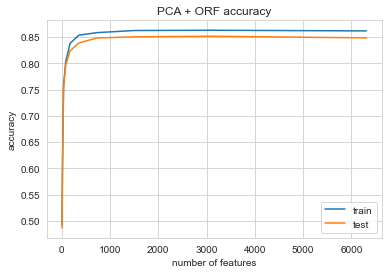

In [82]:
plt.plot([int(n) for n in n_ft_grid], orf_acc_train, label='train')
plt.plot([int(n) for n in n_ft_grid], orf_acc_test, label='test')
plt.xlabel('number of features')
plt.ylabel('accuracy')
plt.title('PCA + ORF accuracy')
plt.legend()
plt.show()

*Видим, что график получается похожим на график для модели с RRF (где-то с 300-400 значения точности выходит на константу около 0.86).*

*Рассмотрим точность в зависимости от отношения n_features / new_dim (аналогично анализу в статье):*

In [85]:
acc_rff = []
acc_orf = []
for m in range(1,11):
    rff_model_ = RFFPipeline(new_dim=50, n_features = 50 * m)
    orf_model_ = ORFPipeline(new_dim=50, n_features = 50 * m)
    rff_model_.fit(x_train, y_train)
    orf_model_.fit(x_train, y_train)
    acc_rff.append(accuracy_score(y_test, rff_model_.predict(x_test)))
    acc_orf.append(accuracy_score(y_test, orf_model_.predict(x_test)))

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

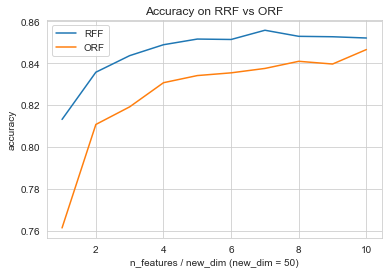

In [87]:
plt.plot(range(1,11), acc_rff, label='RFF')
plt.plot(range(1,11), acc_orf, label='ORF')
plt.xlabel('n_features / new_dim (new_dim = 50)')
plt.ylabel('accuracy')
plt.title('Accuracy on RRF vs ORF')
plt.legend()
plt.show()

*Получаем, что в среднем логистическая регрессия на ORF работает несколько хуже, чем на RRF (впрочем, с увеличением отношения n_features / new_dim разница значительно уменьшается), однако модель с ORF работает намного быстрее.*

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

*Добавим в класс возможность задавать функцию получения признаков (по умолчанию np.cos()):*

In [38]:
class RFFPipeline_2(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, ft_func = np.cos, classifier=LogisticRegression()):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        ft_func, function(np.array): function to implement on w^Tx+b for new features generation
        
        classifier, linear classification model        
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.ft_func = ft_func
        self.classifier = classifier
    
    def decode(self, i):    # for pair generator
        k = math.floor((1+math.sqrt(1+8*i))/2)
        return [k,i-k*(k-1)//2]

    def rand_pairs(self, n, m):    # pair generator
        return np.array([self.decode(i) for i in random.sample(range(n*(n-1)//2),m)])
    
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        if self.use_PCA:
            self.pca_ = PCA(n_components=self.new_dim)
            self.pca_.fit(X)
            X = self.pca_.transform(X)
        
        idx = self.rand_pairs(X.shape[0], 1000000)
        sigma_sq = np.median(((X[idx[:,0]] - X[idx[:,1]]) ** 2).sum(axis=1))
        self.weights_ = np.random.normal(0, 1/np.sqrt(sigma_sq), (self.n_features, X.shape[1]))
        self.intercept_ = np.random.uniform(-np.pi, np.pi, self.n_features)
        X_new = self.ft_func(X.dot(self.weights_.T) + self.intercept_)

        self.classifier.fit(X_new, y)
        return self
        raise NotImplementedError


    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.pca_.transform(X)

        X_new = self.ft_func(X.dot(self.weights_.T) + self.intercept_)
        if hasattr(self.classifier, 'predict_proba'):
            return self.classifier.predict_proba(X_new)
        else:
            if hasattr(self.classifier, 'decision_function'):
                return 1 / (1 + np.exp(-self.classifier.decision_function(X_new)))    # sigmoid
        raise NotImplementedError
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if hasattr(self.classifier, 'classes_'):
            return self.classifier.classes_[np.argmax(self.predict_proba(X), axis=1)]
        return np.argmax(self.predict_proba(X), axis=1)
        raise NotImplementedError

*Рассмотрим модель с взятием знака, сигмоиды, tanh от скалярного произведения. Также рассмотрим использование SGDClassifier(), DecisionTreeClassifier(), RandomForestClassifier().*

In [43]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

def sigmoid(X):
    return 1 / (1 + np.exp(-X))

ft_functions = [np.cos, np.sign, sigmoid, np.tanh]
lin_classifiers = [LogisticRegression(), SGDClassifier(), DecisionTreeClassifier(), RandomForestClassifier(n_estimators=10)]

In [51]:
from tqdm import tqdm

In [52]:
time_dict = dict()
acc_dict = dict()

for classifier in lin_classifiers:
    time_dict[str(classifier)] = dict()
    acc_dict[str(classifier)] = dict()
    for ft_func in tqdm(ft_functions):
        model = RFFPipeline_2(ft_func=ft_func, classifier=classifier)
        start_time = time.time()
        model.fit(x_train, y_train)
        fit_time = time.time() - start_time
        
        start_time = time.time()
        preds = model.predict(x_test)
        pred_time = time.time() - start_time
        
        train_preds = model.predict(x_train)
        
        time_dict[str(classifier)][str(ft_func)] = (fit_time, pred_time)
        acc_dict[str(classifier)][str(ft_func)] = (accuracy_score(y_train, train_preds), accuracy_score(y_test, preds))

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 25%|████████████████████▊                                                              | 1/4 [01:46<05:18, 106.23s/it]C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as

In [54]:
for classifier in lin_classifiers:
    for ft_func in ft_functions:
        class_name = str(classifier)
        func_name = str(ft_func)
        print(class_name, func_name)
        print('\tFitting time: %.4f s\t Predicting time: %.4f s' % time_dict[class_name][func_name])
        print('\tTrain accuracy: %.4f\t Test accuracy: %.4f s' % acc_dict[class_name][func_name])

LogisticRegression() <ufunc 'cos'>
	Fitting time: 99.5319 s	 Predicting time: 1.0554 s
	Train accuracy: 0.8747	 Test accuracy: 0.8574 s
LogisticRegression() <ufunc 'sign'>
	Fitting time: 97.8593 s	 Predicting time: 0.8657 s
	Train accuracy: 0.8558	 Test accuracy: 0.8345 s
LogisticRegression() <function sigmoid at 0x00000201238AC670>
	Fitting time: 100.9011 s	 Predicting time: 1.2955 s
	Train accuracy: 0.8285	 Test accuracy: 0.8136 s
LogisticRegression() <ufunc 'tanh'>
	Fitting time: 109.9661 s	 Predicting time: 1.2831 s
	Train accuracy: 0.8533	 Test accuracy: 0.8415 s
SGDClassifier() <ufunc 'cos'>
	Fitting time: 155.5777 s	 Predicting time: 1.2088 s
	Train accuracy: 0.8844	 Test accuracy: 0.8605 s
SGDClassifier() <ufunc 'sign'>
	Fitting time: 185.0296 s	 Predicting time: 0.6363 s
	Train accuracy: 0.8141	 Test accuracy: 0.7968 s
SGDClassifier() <function sigmoid at 0x00000201238AC670>
	Fitting time: 135.9945 s	 Predicting time: 0.9744 s
	Train accuracy: 0.8393	 Test accuracy: 0.8247 s
S

In [63]:
pd.DataFrame([['%.4f, %.4f' % acc_dict[class_dict][key] for key in acc_dict[class_dict]] for class_dict in acc_dict], 
             columns=['cos', 'sgn', 'sigmoid', 'tanh'],
            index=['LogReg', 'SGDClassifier', 'DT', 'RF'])

,cos,sgn,sigmoid,tanh
LogReg,"0.8747, 0.8574","0.8558, 0.8345","0.8285, 0.8136","0.8533, 0.8415"
SGDClassifier,"0.8844, 0.8605","0.8141, 0.7968","0.8393, 0.8247","0.8676, 0.8472"
DT,"1.0000, 0.7692","1.0000, 0.7585","1.0000, 0.7829","1.0000, 0.7723"
RF,"0.9949, 0.8301","0.9946, 0.8181","0.9949, 0.8375","0.9953, 0.8382"


In [62]:
pd.DataFrame([['%.2f, %.2f' % time_dict[class_dict][key] for key in time_dict[class_dict]] for class_dict in time_dict], 
             columns=['cos', 'sgn', 'sigmoid', 'tanh'],
            index=['LogReg', 'SGDClassifier', 'DT', 'RF'])

,cos,sgn,sigmoid,tanh
LogReg,"99.53, 1.06","97.86, 0.87","100.90, 1.30","109.97, 1.28"
SGDClassifier,"155.58, 1.21","185.03, 0.64","135.99, 0.97","135.31, 1.06"
DT,"507.48, 0.88","51.75, 0.73","651.58, 1.12","507.00, 1.08"
RF,"87.50, 0.93","28.19, 0.71","88.65, 1.09","89.04, 1.25"


*Проанализировав результаты, можно увидеть, что дольше всего обучается DecisionTreeClassifier() с значениями параметров по уолчанию, быстрее всего - RF на 10 деревьях (однако видно, что эти модели переобучаются). По качеству на тестовой выборке наилучший результат получился при взятии cos и использовании SGDClassifier() (впрочем, в первом задании при взятии cos и использовании линейного SVM точность выходила ещё выше). Из рассмотренных функций наименьшую точность дают взятие знака и сигмоиды, наилучшую - cos и tanh. Вероятно, при подборе гиперпараметров для SGDClassifier точность могла бы получиться ещё выше.*